Dataset: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

# Step 1: Get the Data using the Kaggle API

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
api = KaggleApi()

In [3]:
api.authenticate()

In [8]:
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'test.tsv.zip', path = './')
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'train.tsv.zip', path = './')

  0%|                                                                                       | 0.00/494k [00:00<?, ?B/s]

100%|████████████████████████████████████████████████████████████████████████████████| 494k/494k [00:01<00:00, 367kB/s]


  0%|                                                                                      | 0.00/1.28M [00:00<?, ?B/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1.28M/1.28M [00:02<00:00, 594kB/s]

In [9]:
import zipfile

In [10]:
with zipfile.ZipFile('test.tsv.zip', 'r') as zipF:
    zipF.extractall('./')

In [11]:
with zipfile.ZipFile('train.tsv.zip', 'r') as zipF:
    zipF.extractall('./')

# Step 2: Data Preprocessing

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("train.tsv", sep = "\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [8]:
df = df.drop_duplicates(subset=['SentenceId'], keep="first")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


<AxesSubplot:>

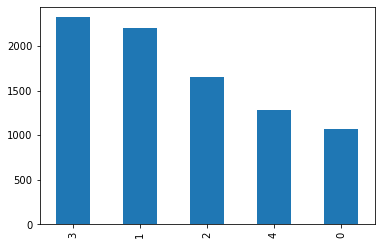

In [9]:
df['Sentiment'].value_counts().plot(kind = 'bar')

In [10]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(8529, 512)

In [11]:
from transformers import BertTokenizer

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [13]:
tokens = tokenizer(df['Phrase'].tolist(), max_length = seq_len, truncation = True, padding = 'max_length', add_special_tokens = True, return_tensors = 'np')

In [14]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
tokens['input_ids']

array([[ 101,  138, 1326, ...,    0,    0,    0],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101,  118,  149, ...,    0,    0,    0],
       [ 101, 1109, 2523, ...,    0,    0,    0],
       [ 101, 1109, 1273, ...,    0,    0,    0]])

In [16]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [17]:
import numpy as np
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [18]:
arr = df['Sentiment'].values
arr, arr.shape

(array([1, 4, 1, ..., 1, 1, 2], dtype=int64), (8529,))

In [19]:
labels = np.zeros((num_samples, arr.max() + 1))
labels.shape

(8529, 5)

In [20]:
labels[np.arange(num_samples), arr] = 1

In [21]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [22]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)